
# Spark-ocr demo for table recognition and free text extraction

The aim of this notebook is to show Spark-OCR abilities for 
* Table recognition
* Free-text extraction

## Set up environment

In [ ]:
import os
from pyspark.ml import PipelineModel
import sparkocr
from sparkocr.transformers import *
from sparkocr.enums import *
from sparkocr.utils import *

from sparkocr.utils import display_images, display_tables

import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

spark = start_spark()
print("Spark OCR Version :", sparkocr.version())

In [ ]:
!gdown --output shareholders.jpg 1e2xnujGxcl0n0mTPNcV_YdlDx0V3NDMS

## Run Spark-ocr

### Load sample

In [3]:
imagePath = "shareholders.jpg"

df = spark.read.format("binaryFile").load(imagePath)
df.show()

+--------------------+--------------------+------+--------------------+
|                path|    modificationTime|length|             content|
+--------------------+--------------------+------+--------------------+
|file:/home/ubuntu...|2024-02-12 17:23:...|385071|[FF D8 FF E0 00 1...|
+--------------------+--------------------+------+--------------------+




### What if no table recognition?

In [14]:
binary_to_image = BinaryToImage()
binary_to_image.setOutputCol("image")
binary_to_image.setImageType(ImageType.TYPE_3BYTE_BGR)

ocr = ImageToText()
ocr.setInputCol("image")
ocr.setOutputCol("text")
ocr.setOcrParams(["preserve_interword_spaces=1", ])
ocr.setOutputSpaceCharacterWidth(10)

pipeline_ocr = PipelineModel(stages=[
    binary_to_image,
    ocr
])

result = pipeline_ocr.transform(df).cache()
print("\n".join([row.text for row in result.select("text").collect()]))

Estimating resolution as 186


 

HISTORY, DEVELOPMENT AND CORPORATE STRUCTURE

 

(iii) Series B Financing

On April 28, 2018, the Company and its subsidiaries entered into the Series B Share
Purchase Agreement with the then Series B Preferred Shareholders, pursuant to which the then
Series B Preferred Shareholders agreed to subscribe for a maximum of 45,908,818 Series B
Preferred Shares in aggregate to be issued by our Company at a subscription price of
approximately US$5.66 per share and an aggregate consideration of approximately US$260
million. The Series B Preferred Shares were issued in full on May 8, 2018 as set forth in the
table below.

 

 

Number of
Series B            Purchase
Name of Shareholder                         Preferred Shares            Amount
(US$)
WuXi Healthcare Ventures                              882,861        4,999,994.99
6 Dimensions Capital, L.P.                             3,354,875       18,999,999.08
6 Dimensions Affiliates Fund, L.P.                       176,572         999,99


### Table data extraction

In [15]:
binary_to_image = BinaryToImage()
binary_to_image.setOutputCol("image")
binary_to_image.setImageType(ImageType.TYPE_3BYTE_BGR)

# Detect tables on the page using pretrained model
# It can be finetuned for have more accurate results for more specific documents
table_detector = ImageTableDetector.pretrained("general_model_table_detection_v2", "en", "clinical/ocr")
table_detector.setInputCol("image")
table_detector.setOutputCol("region")

# Draw detected region's with table to the page
draw_regions = ImageDrawRegions()
draw_regions.setInputCol("image")
draw_regions.setInputRegionsCol("region")
draw_regions.setOutputCol("image_with_regions")
draw_regions.setRectColor(Color.red)

# Extract table regions to separate images
splitter = ImageSplitRegions()
splitter.setInputCol("image")
splitter.setInputRegionsCol("region")
splitter.setOutputCol("table_image")
splitter.setDropCols("image")

# Detect cells on the table image
cell_detector = ImageTableCellDetector()
cell_detector.setInputCol("table_image")
cell_detector.setOutputCol("cells")
cell_detector.setAlgoType("morphops")
cell_detector.setDrawDetectedLines(True)

# Extract text from the detected cells 
table_recognition = ImageCellsToTextTable()
table_recognition.setInputCol("table_image")
table_recognition.setCellsCol('cells')
table_recognition.setMargin(3)
table_recognition.setStrip(True)
table_recognition.setOutputCol('table')

# Erase detected table regions
fill_regions = ImageDrawRegions()
fill_regions.setInputCol("image")
fill_regions.setInputRegionsCol("region")
fill_regions.setOutputCol("image_1")
fill_regions.setRectColor(Color.white)
fill_regions.setFilledRect(True)

# OCR
ocr = ImageToText()
ocr.setInputCol("image_1")
ocr.setOutputCol("text")
ocr.setOcrParams(["preserve_interword_spaces=1", ])
ocr.setKeepLayout(True)
ocr.setOutputSpaceCharacterWidth(8)

pipeline_table = PipelineModel(stages=[
    binary_to_image,
    table_detector,
    draw_regions,
    fill_regions,
    splitter,
    cell_detector,
    table_recognition,
    ocr
])

tables_results = pipeline_table.transform(df).cache()

general_model_table_detection_v2 download started this may take some time.
Approximate size to download 264.7 MB


In [16]:
tables_results.show()

Estimating resolution as 182                                        (0 + 1) / 1]


+--------------------+--------------------+--------------------+------+-------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------------+---------+--------------------+--------------------+
|               image|                path|    modificationTime|length|pagenum|  image_with_regions|             image_1|         table_image|              region|               cells|        output_image|               table|       confidence|exception|                text|           positions|
+--------------------+--------------------+--------------------+------+-------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------------+---------+--------------------+--------------------+
|{file:/home/ubunt...|file:/home/ubuntu...|2024-02-12 17:23:...|385071|      0|{file:/home/ubunt...|{file:/ho


    Image #0:
    Origin: file:/home/ubuntu/notebooks/examples/visual/cTDaR_t10096.jpg
    Resolution: 0 dpi
    Width: 1190 px
    Height: 1588 px
    Mode: ImageType.TYPE_3BYTE_BGR
    Number of channels: 3


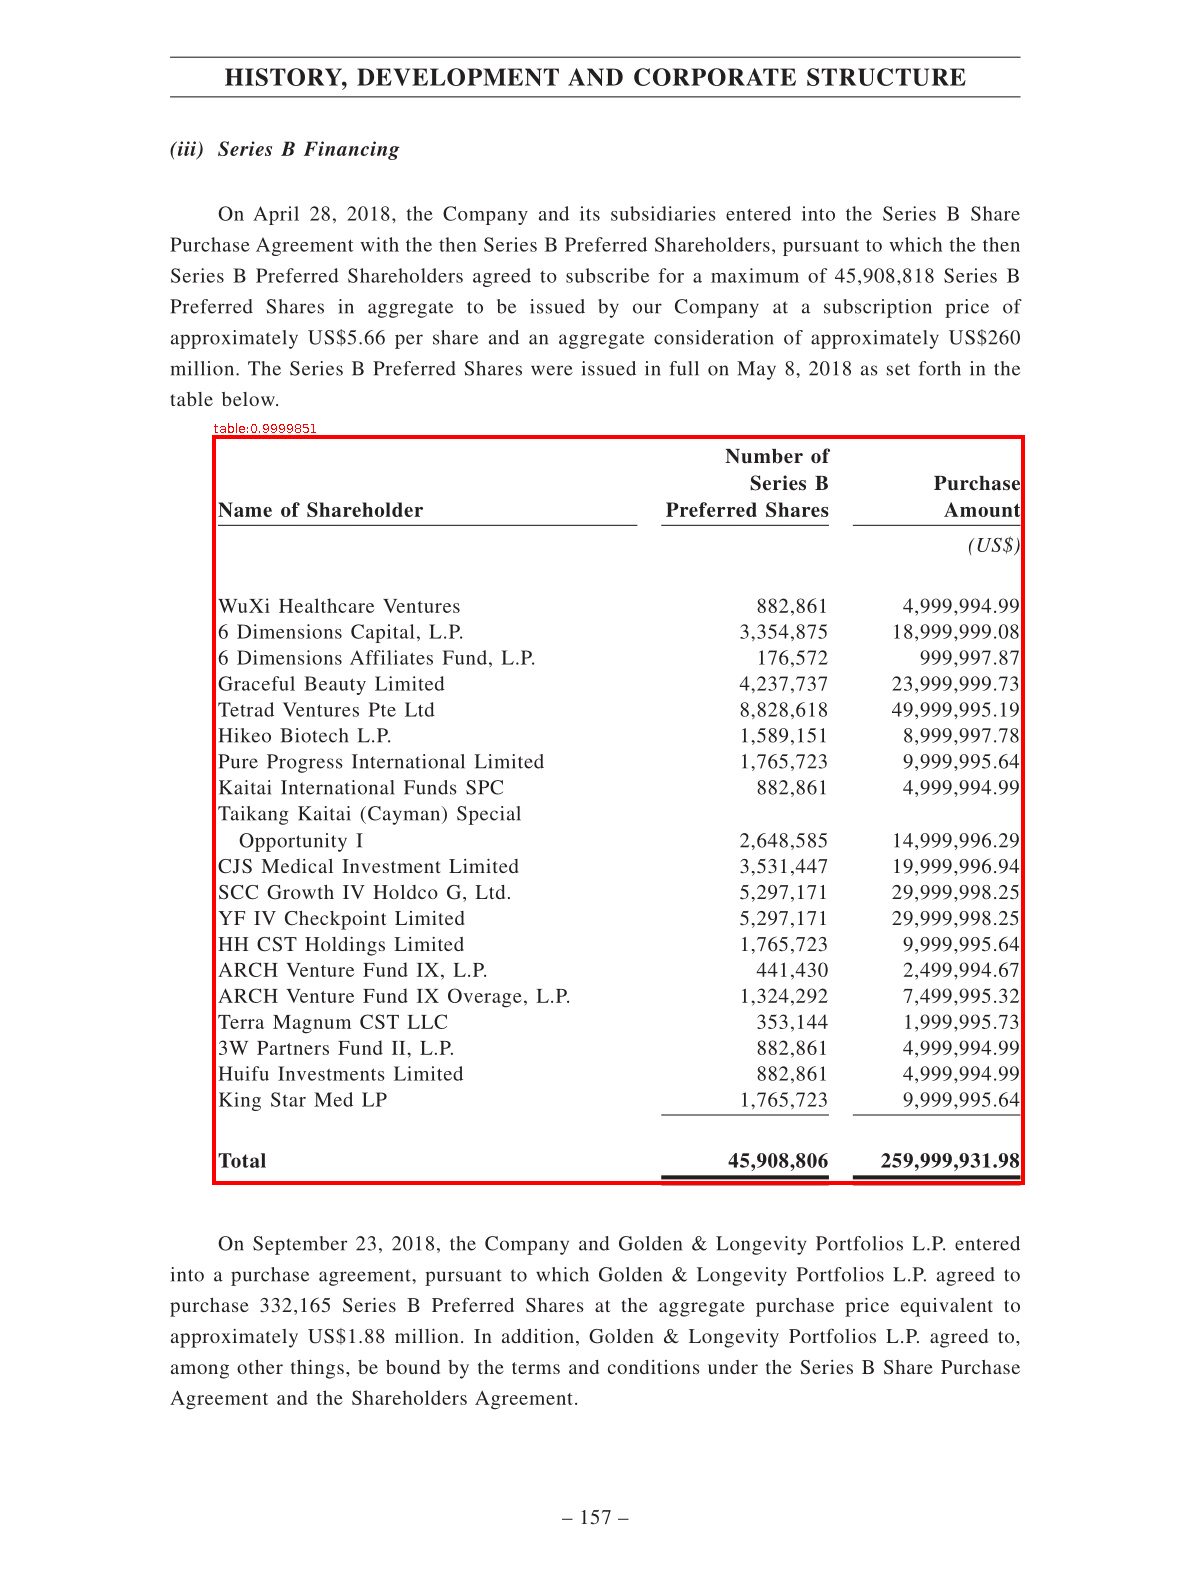

In [7]:
display_images(tables_results, "image_with_regions")

## Tables

In [ ]:
display_tables(tables_results)

## Free text

In [ ]:
tables_results.select("text").show(truncate=False)

## Processing of PDF


In [10]:
!gdown --output budget.pdf 1AhAKlyxX_PEWI9bI0M0KH0wgzrKOpLTt

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.18) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
Downloading...
From: https://drive.google.com/uc?id=1AhAKlyxX_PEWI9bI0M0KH0wgzrKOpLTt
To: /home/ubuntu/notebooks/examples/visual/budget.pdf
100%|████████████████████████████████████████| 339k/339k [00:00<00:00, 17.9MB/s]


In [18]:
pdfPath = "budget.pdf"

pdf_df = spark.read.format("binaryFile").load(pdfPath)

pdf_to_image = PdfToImage() \
    .setInputCol("content") \
    .setOutputCol("image") \
    .setImageType(ImageType.TYPE_3BYTE_BGR) \
    .setKeepInput(True)

pipeline_table_pdf = PipelineModel(stages=[
    pdf_to_image,
    table_detector,
    draw_regions,
    fill_regions,
    splitter,
    cell_detector,
    table_recognition,
    ocr
])

tables_results_pdf = pipeline_table_pdf.transform(pdf_df).cache()

24/02/12 17:24:04 WARN PDTrueTypeFont: Using fallback font 'LiberationSans' for 'Arial,BoldItalic'
24/02/12 17:24:04 WARN PDTrueTypeFont: Using fallback font 'LiberationSans' for 'Arial,Bold'
24/02/12 17:24:04 WARN PDTrueTypeFont: Using fallback font 'LiberationSans' for 'Helvetica,Bold'
24/02/12 17:24:04 WARN PDTrueTypeFont: Using fallback font 'LiberationSans' for 'Helvetica'
Estimating resolution as 327=========================>              (3 + 1) / 4]



    Image #0:
    Origin: file:/home/ubuntu/notebooks/examples/visual/budget.pdf
    Resolution: 0 dpi
    Width: 3507 px
    Height: 2480 px
    Mode: ImageType.TYPE_3BYTE_BGR
    Number of channels: 3


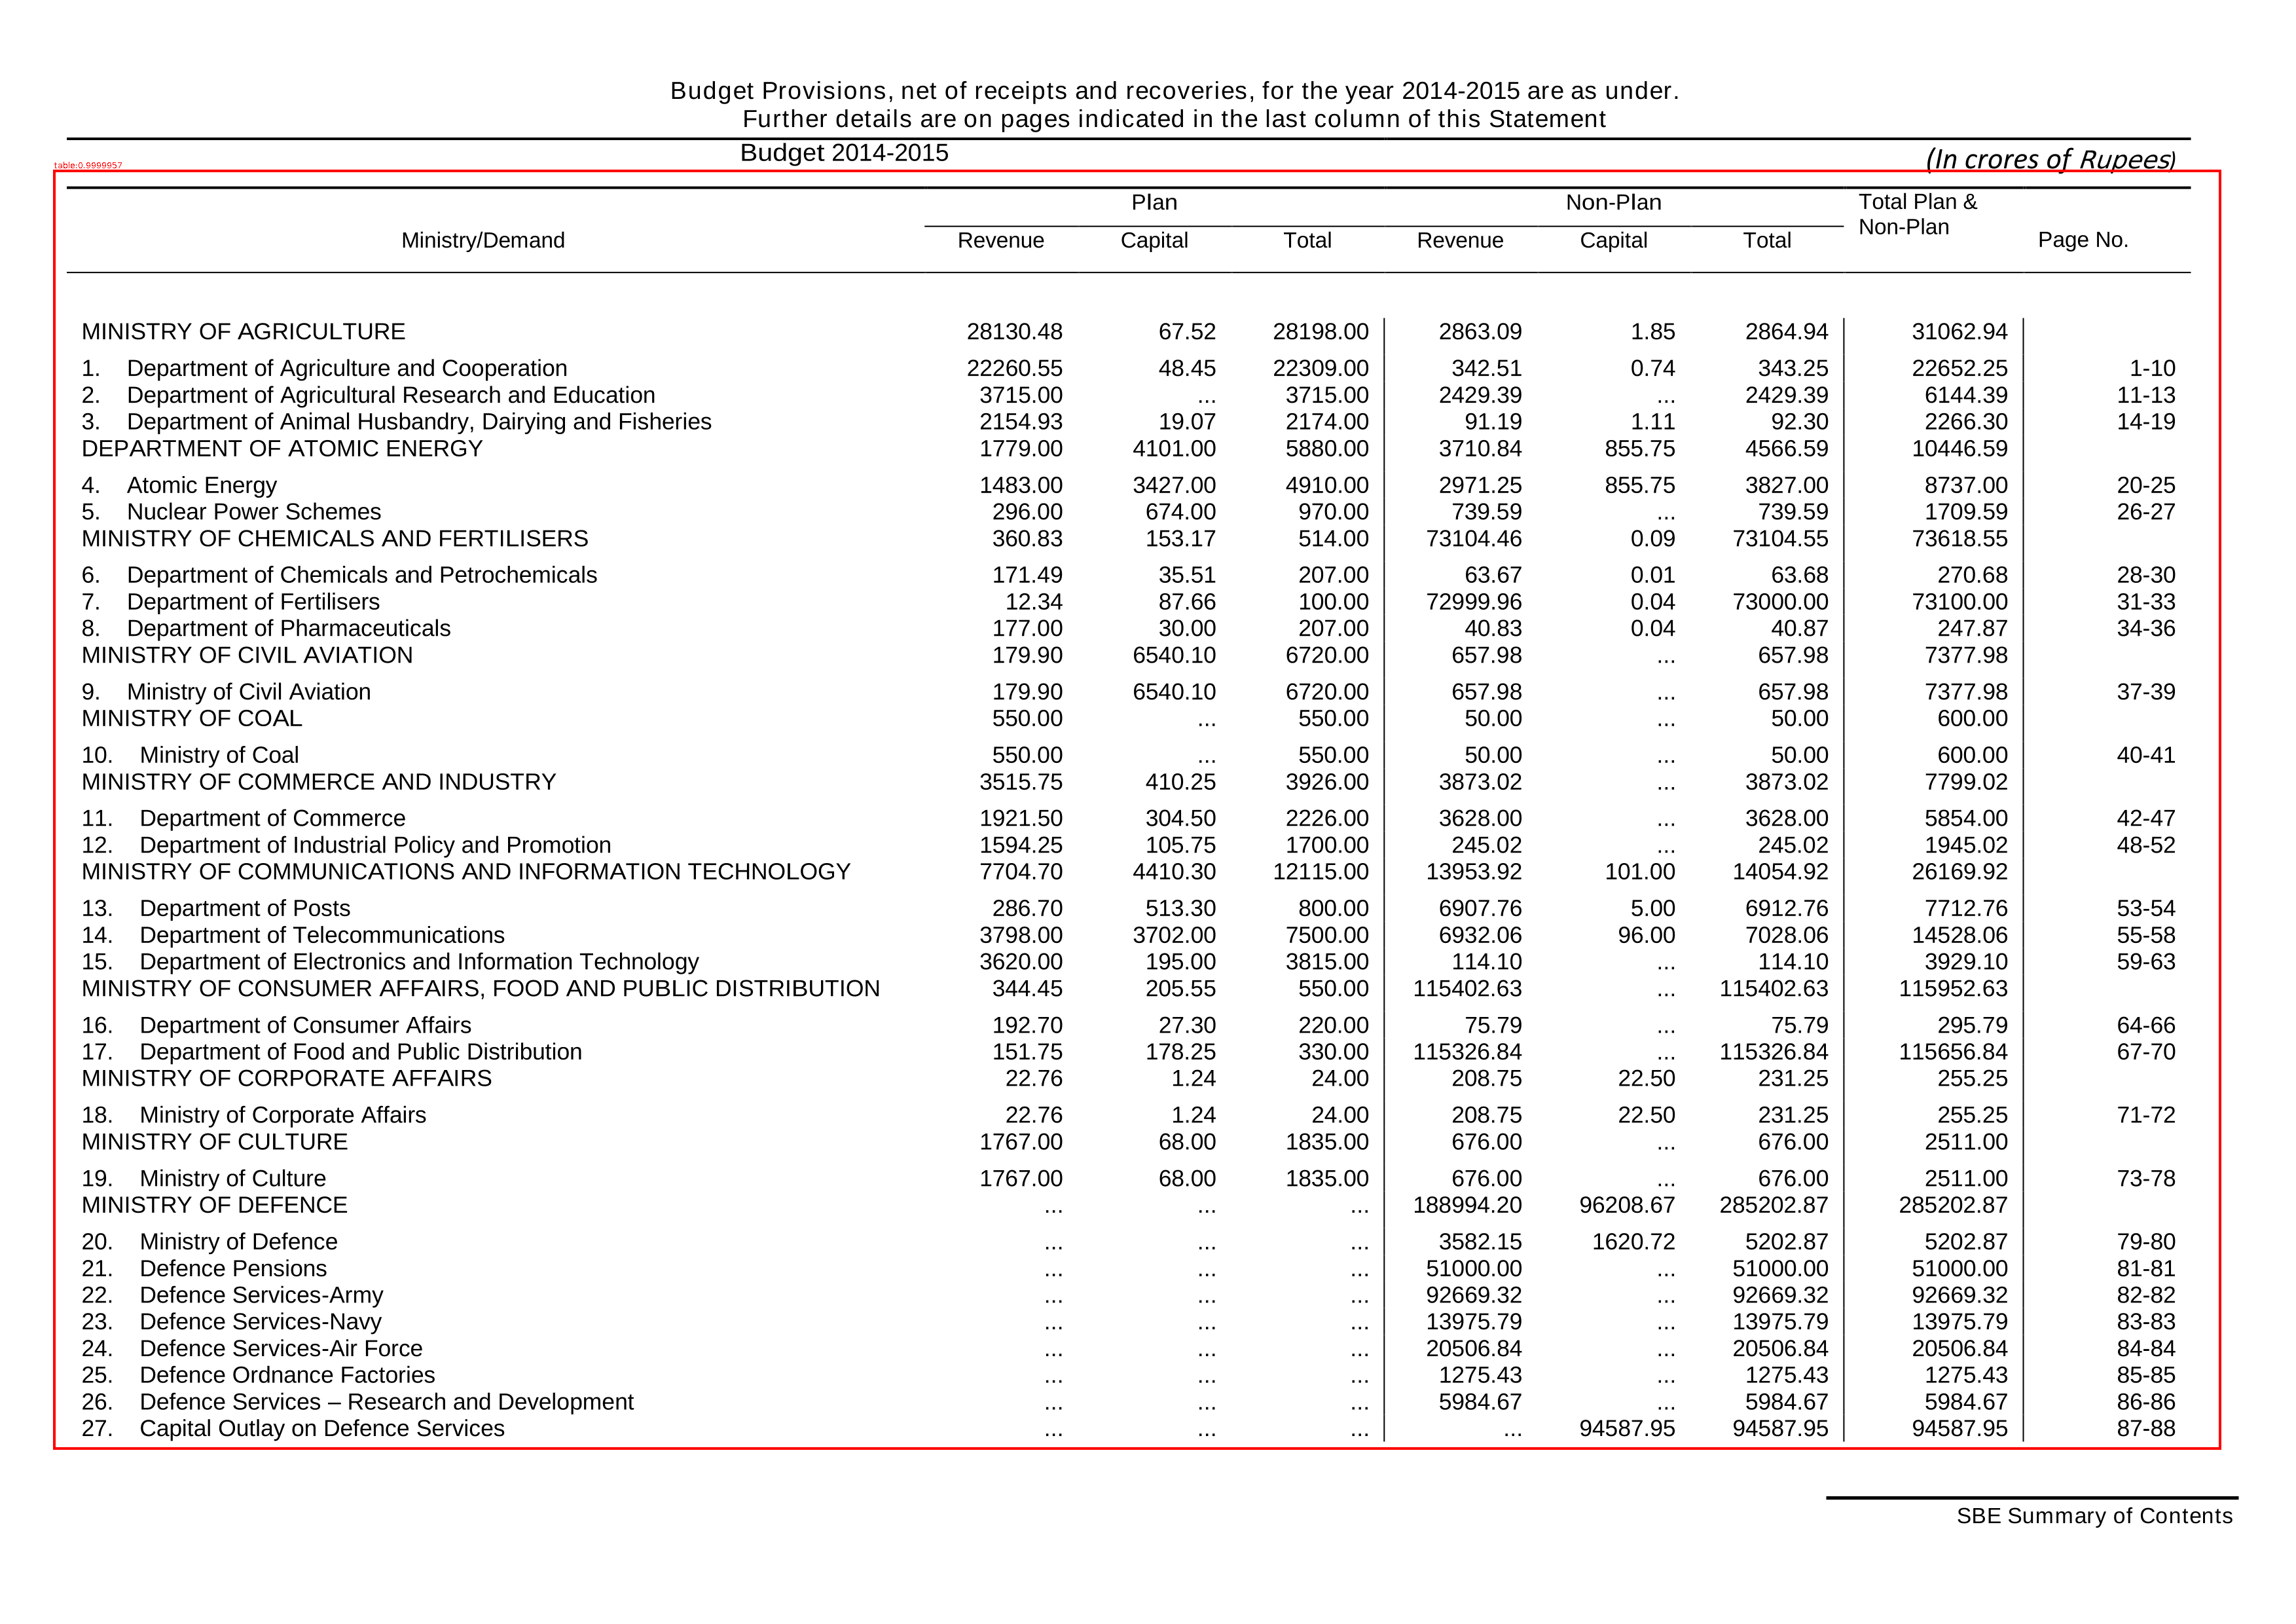

CPU times: user 454 ms, sys: 136 ms, total: 591 ms
Wall time: 18.3 s


In [12]:
%%time
display_images(tables_results_pdf, "image_with_regions")

Table extracted from pdf

In [ ]:
display_tables(tables_results_pdf)